# Network saturation of a Grid'5000 cluster

The goal here is to find the `bb_bw` term of the Simgrid platform file.

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def read_csv(archive_name, file_name, columns):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)), names=columns)
    res['archive_name'] = archive_name
    res['file_name'] = file_name
    return res

def read_result(archive_name, file_name):
    res = read_csv(archive_name, file_name, columns=['rank', 'operation', 'size', 'start', 'duration'])
    res['start'] *= 1e-3
    res['duration'] *= 1e-3
    res['stop'] = res['start'] + res['duration']
    return res

def read_all_result(archive_name, dir_name):
    return pandas.concat([
        read_result(archive_name, os.path.join(dir_name, 'load_alltoall.csv')),
        read_result(archive_name, os.path.join(dir_name, 'load_send.csv')),
        read_result(archive_name, os.path.join(dir_name, 'load_sendrecv_diff.csv')),
        read_result(archive_name, os.path.join(dir_name, 'load_sendrecv_same.csv')),
    ])

In [2]:
df = read_all_result('saturation/1/grenoble_2020-07-03_1938926.zip', 'exp_monocore')
print(len(df))
df.head()

5950


,rank,operation,size,start,duration,archive_name,file_name,stop
0,0,MPI_Alltoall,4000000,0.181739,0.001089,saturation/1/grenoble_2020-07-03_1938926.zip,exp_monocore/load_alltoall.csv,0.182828
1,0,MPI_Alltoall,4000000,0.183575,0.000709,saturation/1/grenoble_2020-07-03_1938926.zip,exp_monocore/load_alltoall.csv,0.184284
2,0,MPI_Alltoall,4000000,0.184338,0.000657,saturation/1/grenoble_2020-07-03_1938926.zip,exp_monocore/load_alltoall.csv,0.184995
3,0,MPI_Alltoall,4000000,0.185062,0.002442,saturation/1/grenoble_2020-07-03_1938926.zip,exp_monocore/load_alltoall.csv,0.187504
4,0,MPI_Alltoall,4000000,0.188535,0.001746,saturation/1/grenoble_2020-07-03_1938926.zip,exp_monocore/load_alltoall.csv,0.190281


## Overview of the experiment (Gantt chart)

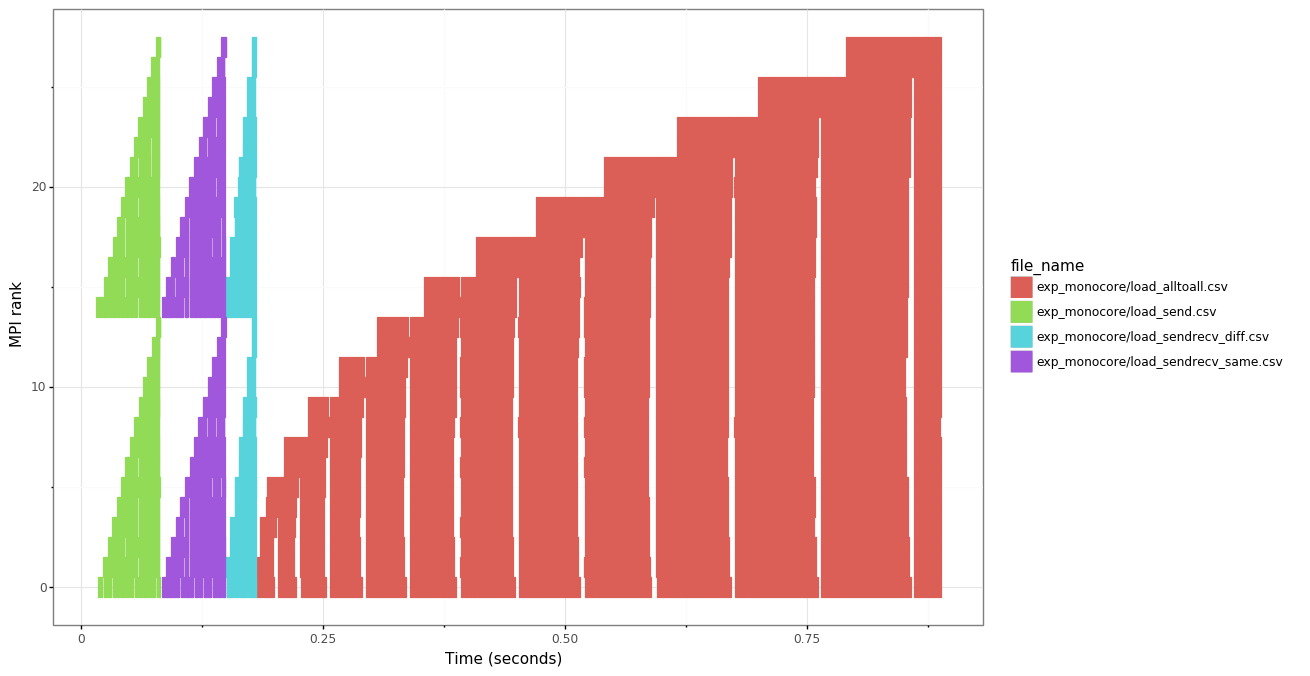

<ggplot: (8780310252201)>

In [3]:
df['ymin'] = df['rank'] - 0.5
df['ymax'] = df['rank'] + 0.5
(ggplot(df)
 + aes(xmin='start', xmax='stop', ymin='ymin', ymax='ymax', fill='file_name', color='file_name')
 + geom_rect()
 + theme_bw()
 + xlab('Time (seconds)')
 + ylab('MPI rank')
)

In [4]:
df['exp_id'] = -1
for fname in df['file_name'].unique():
    total_exp = len(df[(df['file_name'] == fname) & (df['rank'] == 0)])
    print(total_exp)
    for rank in df['rank'].unique():
        thisrank_exp = len(df[(df['file_name'] == fname) & (df['rank'] == rank)])
        df.loc[(df['file_name'] == fname) & (df['rank'] == rank), 'exp_id'] = range(total_exp-thisrank_exp, total_exp)

42
140
70
140


In [5]:
nb_nodes = df.groupby(['file_name', 'exp_id'])[['operation']].count()
nb_nodes
df = df.set_index(['file_name', 'exp_id']).join(nb_nodes, rsuffix='_count').reset_index()
df.head()

,file_name,exp_id,rank,operation,size,start,duration,archive_name,stop,ymin,ymax,operation_count
0,exp_monocore/load_alltoall.csv,0,0,MPI_Alltoall,4000000,0.181739,0.001089,saturation/1/grenoble_2020-07-03_1938926.zip,0.182828,-0.5,0.5,2
1,exp_monocore/load_alltoall.csv,0,1,MPI_Alltoall,4000000,0.181341,0.001773,saturation/1/grenoble_2020-07-03_1938926.zip,0.183114,0.5,1.5,2
2,exp_monocore/load_alltoall.csv,1,0,MPI_Alltoall,4000000,0.183575,0.000709,saturation/1/grenoble_2020-07-03_1938926.zip,0.184284,-0.5,0.5,2
3,exp_monocore/load_alltoall.csv,1,1,MPI_Alltoall,4000000,0.183175,0.000529,saturation/1/grenoble_2020-07-03_1938926.zip,0.183704,0.5,1.5,2
4,exp_monocore/load_alltoall.csv,2,0,MPI_Alltoall,4000000,0.184338,0.000657,saturation/1/grenoble_2020-07-03_1938926.zip,0.184995,-0.5,0.5,2


## Evolution of the node bandwidth for each part of the experiment

In [6]:
df['bw'] = df['size'] / df['duration'] * 8 * 1e-9
grouped = df.groupby(['file_name', 'exp_id'])[['bw']].agg(['count', 'sum'])
grouped.columns = grouped.columns.droplevel()
grouped = grouped.reset_index()
grouped['bw'] = grouped['sum']
grouped.loc[grouped['file_name'].str.contains('alltoall'), 'bw'] *= grouped['count']  # this is an alltoall, so each node sends its buffer N times, so we have to multiply the bandwidth by N
grouped['theoretical_bw'] = 100 * grouped['count']
grouped.head()

,file_name,exp_id,count,sum,bw,theoretical_bw
0,exp_monocore/load_alltoall.csv,0,2,47.433262,94.866524,200
1,exp_monocore/load_alltoall.csv,1,2,105.625485,211.250970,200
2,exp_monocore/load_alltoall.csv,2,2,111.451339,222.902677,200
3,exp_monocore/load_alltoall.csv,3,4,45.964791,183.859163,400
4,exp_monocore/load_alltoall.csv,4,4,78.510782,314.043128,400


In [7]:
def do_plot(df, filename):
    return (ggplot(df[df['file_name'] == filename])
     + aes(x='count', y='bw')
     + geom_point()
     + geom_line(aes(y='theoretical_bw'), linetype='dashed')
     + theme_bw()
     + ylab('Bandwidth (Gbps)')
     + xlab('Number of nodes')
     + scale_x_continuous(breaks=df['count'].unique())
     + expand_limits(y=0)
     + ggtitle(filename)
    )

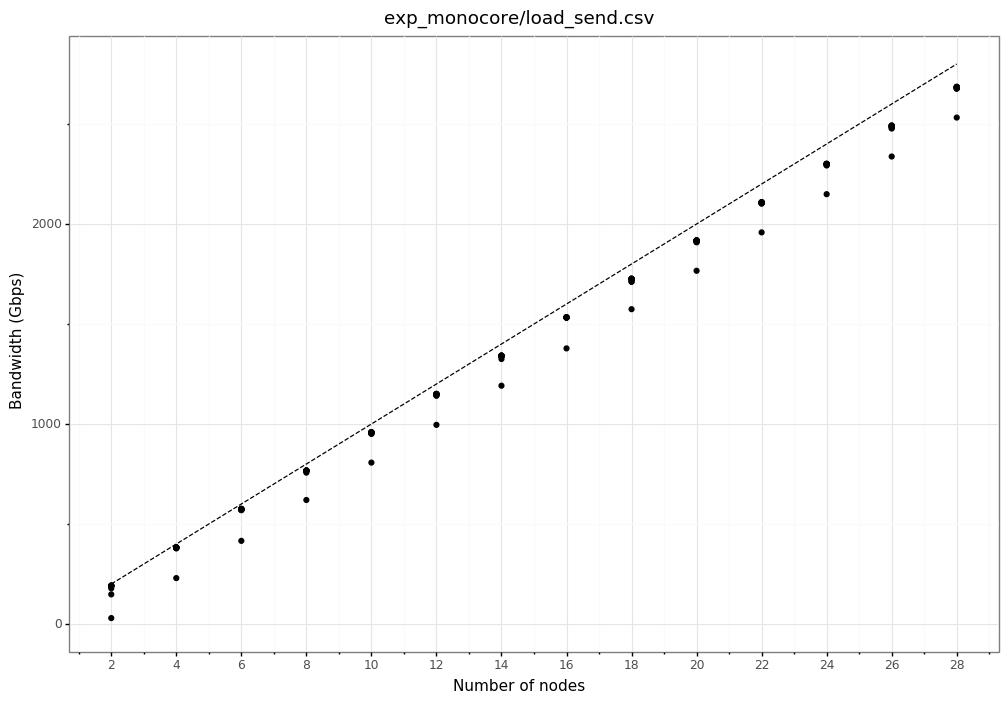

<ggplot: (8780305293807)>

In [8]:
do_plot(grouped, 'exp_monocore/load_send.csv')

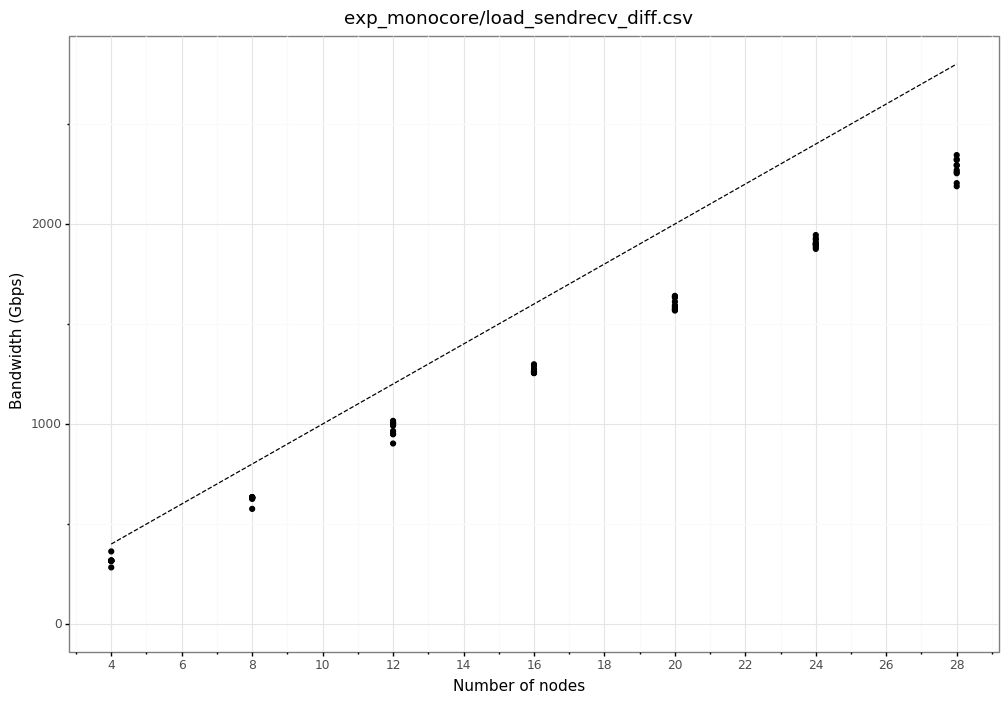

<ggplot: (-9223363256552416519)>

In [9]:
do_plot(grouped, 'exp_monocore/load_sendrecv_diff.csv')

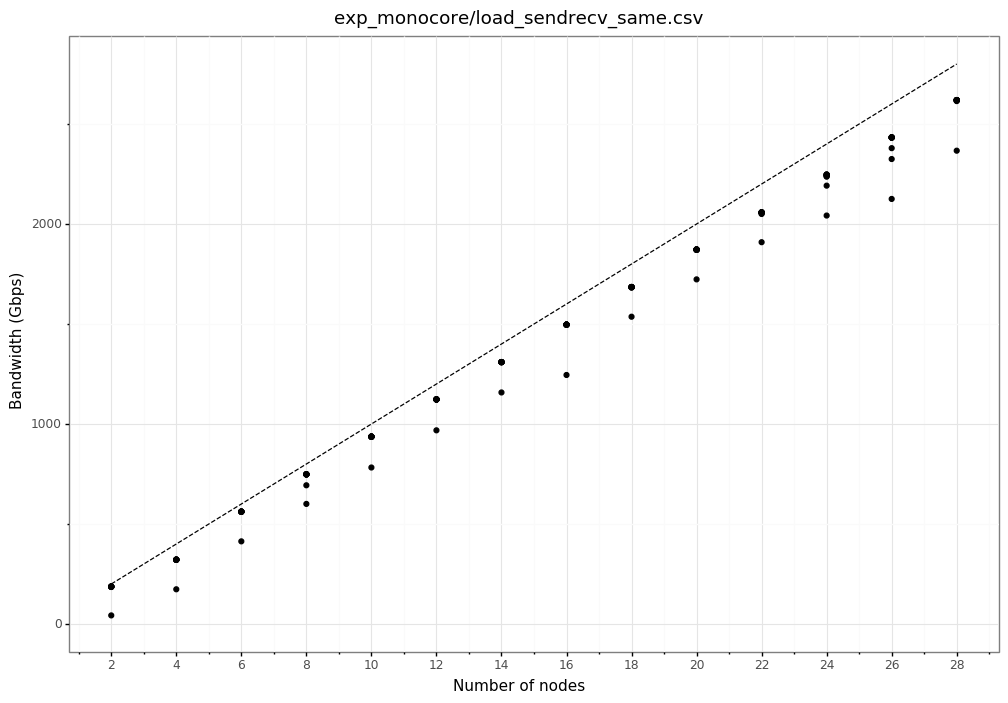

<ggplot: (8780302278134)>

In [10]:
do_plot(grouped, 'exp_monocore/load_sendrecv_same.csv')

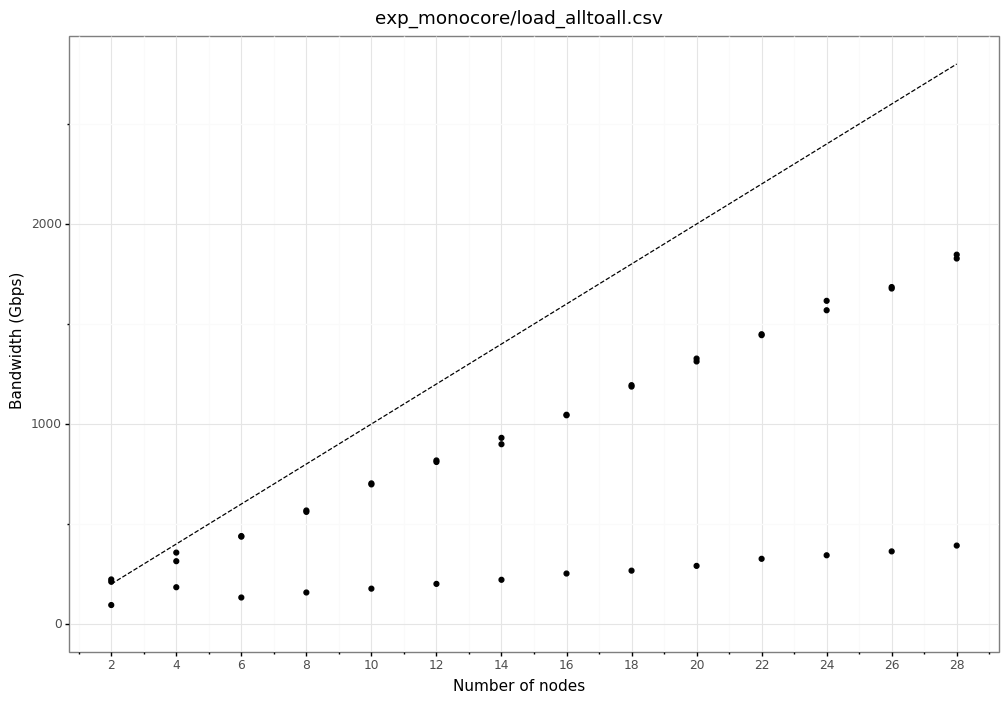

<ggplot: (-9223363256552495528)>

In [11]:
do_plot(grouped, 'exp_monocore/load_alltoall.csv')